In [1]:
! pip install pywph==1.0

Reason for being yanked: Wrong requirements.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywph as pw
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import time
import scipy.optimize as opt

In [3]:
# importing files from google drive
from google.colab import drive
drive.mount('/content/drive')

nbody = np.load('drive/MyDrive/camels data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy')
mgas = np.load('drive/MyDrive/camels data/Maps_Mgas_SIMBA_LH_z=0.00.npy')

Mounted at /content/drive


In [4]:
M, N = 256, 256
J = 7
L = 8
dn = 0

nbody_data = np.log(nbody[0])
mgas_data = np.log(mgas[0])

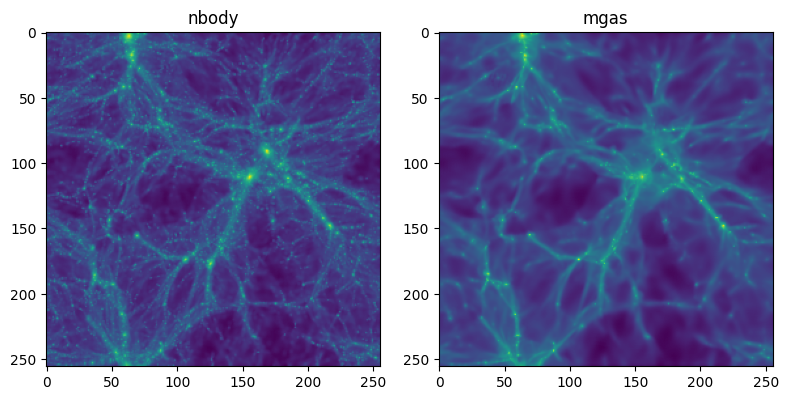

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))

axs[0].imshow(nbody_data)
axs[1].imshow(mgas_data)

axs[0].set_title('nbody')
axs[1].set_title('mgas')

fig.tight_layout()
fig.show()

In [19]:
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device=0) # operator
wph_op.load_model(cross_moments=True)

# get joint coefficients
coeff = wph_op([nbody_data, mgas_data], cross=True, norm='auto')#.cpu().numpy()
print(coeff.shape)

torch.Size([3264])


In [20]:
# run on a GPU device
if torch.cuda.is_available():
    wph_op.to(0)

In [21]:
# generate a noise image as an initial guess
guess = np.random.normal(nbody_data.mean(), nbody_data.std(), (2, 256, 256))
print(guess.shape)

(2, 256, 256)


In [22]:
# optimizer

count = 0

def objective(y):
    global count
    print(f"Evaluation: {count}")
    start_time = time.time()
    loss_tot = torch.zeros(1)

    Y = y.reshape((2, M, N)) # reshape y

    # calculate loss
    Y, chunks = wph_op.preconfigure(Y, requires_grad=True)
    for i in range(chunks):
        y_coeffs_chunk, indices = wph_op(Y, i, norm='auto', ret_indices=True) # get coefficients and indice
        loss = torch.sum(torch.abs(y_coeffs_chunk - coeff[indices])** 2) # compute residual
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del y_coeffs_chunk, indices, loss

    y_final = Y.grad.cpu().numpy().astype(y.dtype) # reshape gradient
    print(f"Loss: {loss_tot.item()} (computed in {(time.time() - start_time):.2f}s)")
    count += 1
    return loss_tot.item(), y_final.ravel()



In [23]:
result = opt.minimize(objective, guess.ravel(), method='L-BFGS-B', jac=True, tol=None, options={"maxiter": 300, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20})
final_loss, final_guess, niter, msg = result['fun'], result['x'], result['nit'], result['message']
final_guess = final_guess.reshape(guess.shape)
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")

Evaluation: 0
Loss: 19095.884765625 (computed in 0.51s)
Evaluation: 1
Loss: 18832.498046875 (computed in 0.51s)
Evaluation: 2
Loss: 17808.564453125 (computed in 0.51s)
Evaluation: 3
Loss: 14162.2138671875 (computed in 0.51s)
Evaluation: 4
Loss: 3953.666748046875 (computed in 0.53s)
Evaluation: 5
Loss: 1766.098876953125 (computed in 0.51s)
Evaluation: 6
Loss: 807.9550170898438 (computed in 0.53s)
Evaluation: 7
Loss: 481.59320068359375 (computed in 0.52s)
Evaluation: 8
Loss: 339.2324523925781 (computed in 0.52s)
Evaluation: 9
Loss: 239.8071746826172 (computed in 0.51s)
Evaluation: 10
Loss: 125.30836486816406 (computed in 0.51s)
Evaluation: 11
Loss: 77.6224594116211 (computed in 0.51s)
Evaluation: 12
Loss: 52.41676330566406 (computed in 0.52s)
Evaluation: 13
Loss: 42.02846145629883 (computed in 0.51s)
Evaluation: 14
Loss: 34.0470085144043 (computed in 0.52s)
Evaluation: 15
Loss: 29.400815963745117 (computed in 0.51s)
Evaluation: 16
Loss: 25.04973602294922 (computed in 0.51s)
Evaluation: 1

In [24]:
sim1 = final_guess[0]
sim2 = final_guess[1]

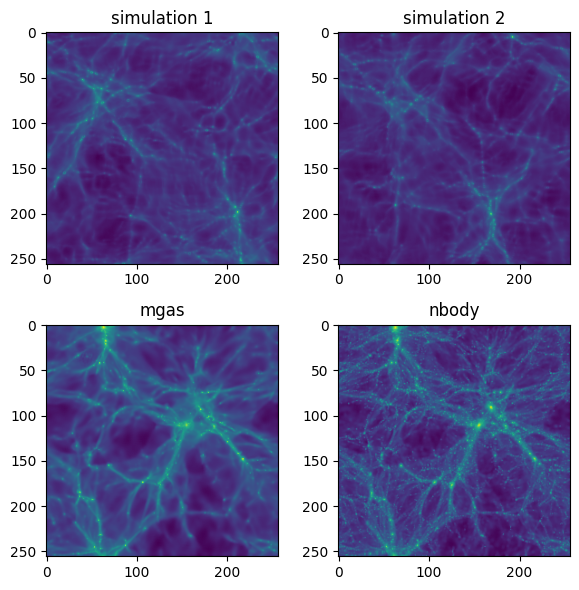

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

axs[0,0].imshow(sim1)
axs[0,1].imshow(sim2)
axs[1,1].imshow(nbody_data)
axs[1,0].imshow(mgas_data)

axs[0,0].set_title('simulation 1')
axs[0,1].set_title('simulation 2')
axs[1,1].set_title('nbody')
axs[1,0].set_title('mgas')

fig.tight_layout()
fig.show()

In [26]:
wph1 = wph_op(sim1, ret_wph_obj=True) # WPH object
s11_guess_1 = wph1.get_coeffs("S11")[0]
wph2 = wph_op(sim2, ret_wph_obj=True)
s11_guess_2 = wph2.get_coeffs("S11")[0]

wph_nbody = wph_op(nbody_data, ret_wph_obj=True)
s11_guess_nbody = wph_nbody.get_coeffs("S11")[0]

wph_mgas = wph_op(mgas_data, ret_wph_obj=True)
s11_guess_mgas = wph_mgas.get_coeffs("S11")[0]

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


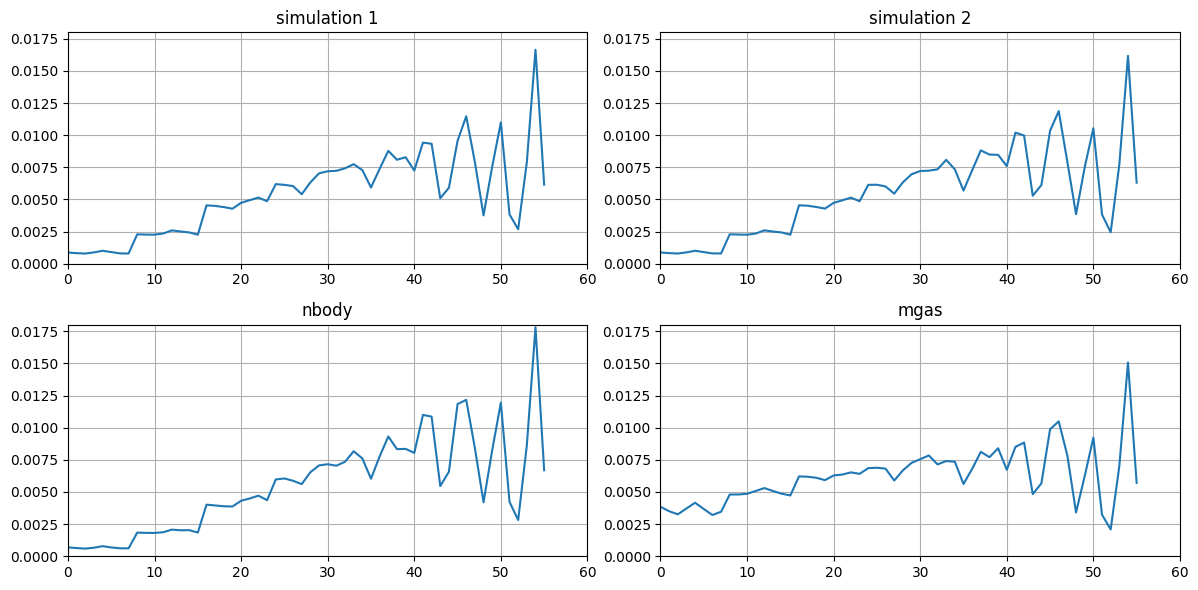

In [27]:
# compare S11 coefficients
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0,0].plot(s11_guess_1)
axs[0,1].plot(s11_guess_2)
axs[1,1].plot(s11_guess_nbody)
axs[1,0].plot(s11_guess_mgas)

axs[0,0].set_title('simulation 1')
axs[0,1].set_title('simulation 2')
axs[1,0].set_title('nbody')
axs[1,1].set_title('mgas')

for i in range(2):
    for j in range(2):
      axs[i,j].set_xlim(0,60)
      axs[i,j].set_ylim(0,0.018)
      axs[i,j].grid()


fig.tight_layout()
fig.show()

In [28]:
wph1 = wph_op(sim1, ret_wph_obj=True) # WPH object
s10_guess_1 = wph1.get_coeffs("S10")[0]
wph2 = wph_op(sim2, ret_wph_obj=True)
s10_guess_2 = wph2.get_coeffs("S10")[0]

wph_nbody = wph_op(nbody_data, ret_wph_obj=True)
s10_guess_nbody = wph_nbody.get_coeffs("S10")[0]

wph_mgas = wph_op(mgas_data, ret_wph_obj=True)
s10_guess_mgas = wph_mgas.get_coeffs("S10")[0]

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


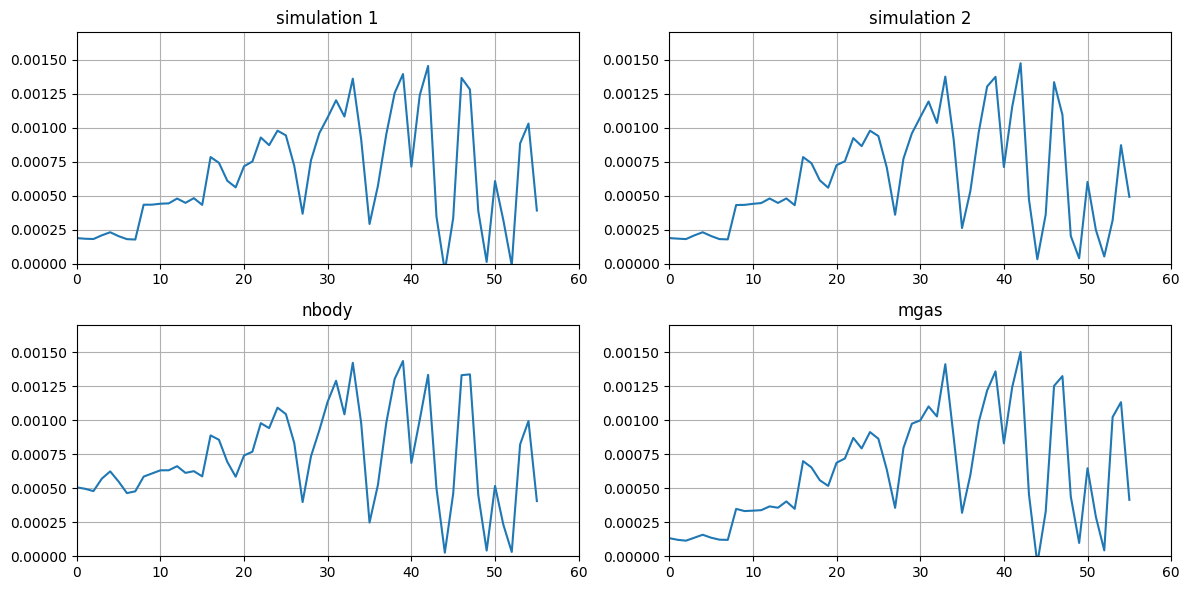

In [29]:
# compare S10 coefficients
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0,0].plot(s10_guess_1)
axs[0,1].plot(s10_guess_2)
axs[1,0].plot(s10_guess_nbody)
axs[1,1].plot(s10_guess_mgas)

axs[0,0].set_title('simulation 1')
axs[0,1].set_title('simulation 2')
axs[1,0].set_title('nbody')
axs[1,1].set_title('mgas')

for i in range(2):
    for j in range(2):
      axs[i,j].set_xlim(0,60)
      axs[i,j].set_ylim(0,0.0017)
      axs[i,j].grid()


fig.tight_layout()
fig.show()